In [ ]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 7.1 MB/s 
     |████████████████████████████████| 18.0 MB 357 kB/s 
     |████████████████████████████████| 240 kB 50.4 MB/s 
     |████████████████████████████████| 54 kB 1.4 MB/s 
     |████████████████████████████████| 112 kB 39.7 MB/s 
     |████████████████████████████████| 1.6 MB 14.7 MB/s 
     |████████████████████████████████| 943 kB 28.1 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 37.5 MB 1.7 MB/s 
     |████████████████████████████████| 4.1 MB 42.1 MB/s 
     |████████████████████████████████| 112 kB 64.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.2-py3-none-any.whl size=12109 sha256=e211787846558b382ffd738d67162cd32b6c6fdcfe96ad0c27feb8b6d96c507a
  Stored in directory: /root/.cache/pip/wheels/e6/bd/f3/26c31

In [ ]:
import pandas as pd
import itertools
from qiskit import Aer
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pickle

In [ ]:
from qiskit import IBMQ
from qkmeans import *

In [ ]:
IBMQ.save_account('fb96d86e9506b6b01fe15c6a4d309eda388c65c328f3c81874f17878510f40737b27b915a50ac914d9c844e9ac6690e2c5f2d3fb6c1d0442960c812e06c54d26')

# Coherent noise RY(theta)

In [ ]:
from qiskit.circuit.library import RYGate
from qiskit.providers.aer.noise import NoiseModel, ReadoutError, depolarizing_error, coherent_unitary_error
import numpy as np

In [ ]:
X, y = load_iris(return_X_y=True, as_frame=False)
X, y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [ ]:
total_qubits = 2 * int(np.ceil(np.log2(X.shape[1]))) + 1
max_epsilon = np.pi/6
angles = 4
epsilons = np.linspace(0,max_epsilon,angles+1)[2:3]
noise_models = {}

for epsilon in epsilons:
  ry_overrotation_noise_model = NoiseModel()
  epsilon_rotation = RYGate(epsilon).to_matrix()
  over_rotation = coherent_unitary_error(epsilon_rotation)
  for qubit in list(range(total_qubits)):
    ry_overrotation_noise_model.add_quantum_error(over_rotation, ['id', 'ry', 'rz', 'sx'], qubits = [qubit])
  
  noise_models[epsilon] = ry_overrotation_noise_model

print('The noise models are:')
for key in noise_models:
  print(key, noise_models[key])

The noise models are:
0.2617993877991494 NoiseModel:
  Basis gates: ['cx', 'id', 'ry', 'rz', 'sx']
  Instructions with noise: ['rz', 'ry', 'id', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('ry', (0,)), ('ry', (1,)), ('ry', (2,)), ('ry', (3,)), ('ry', (4,)), ('rz', (0,)), ('rz', (1,)), ('rz', (2,)), ('rz', (3,)), ('rz', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,))]


In [ ]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = Aer.get_backend('aer_simulator')
qkmeans_noisy_instances = []

#qkmeans_instances = [QuantumKMeans(backend=backend, n_clusters=i, init='random', verbose=True, map_type='probability', max_iter=50, tol=0.01, shots=2048).fit(X, batch=False) for i in range(2,11)]
#qkmeans_noisy_instances.append(qkmeans_instances)
#pickle.dump(qkmeans_noisy_instances, open("qkmeans_noisy_instances.p", "wb"))
for key in noise_models:
  print('Epsilon: ',key)
  ry_overrotation_noise_model = noise_models[key]
  qkmeans_instances = [QuantumKMeans(backend=backend, n_clusters=i, init='random', verbose=True, map_type='probability', max_iter=50, tol=0.01, shots=2048, noise_model=ry_overrotation_noise_model).fit(X, batch=False) for i in range(2,11)]
  qkmeans_noisy_instances.append(qkmeans_instances)
  pickle.dump(qkmeans_noisy_instances, open("qkmeans_noisy_instances.p", "wb"))

Streaming output truncated to the last 5000 lines.
0  5.006000  3.428000  1.462000  0.246000
1  7.020000  2.886667  5.953333  2.000000
2  6.621429  3.150000  5.664286  2.235714
3  6.616667  2.941667  5.091667  1.725000
4  5.990000  2.960000  5.110000  2.040000
5  5.809677  2.680645  4.022581  1.229032
6  6.044444  2.877778  4.727778  1.505556
Centers are [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 6 5 5 3 6 6 5 5 5 5 5 5 6 5 5 6 5 6 5 6 5 6 6
 5 5 3 3 6 5 5 5 5 6 6 6 5 5 5 5 5 6 5 5 6 5 5 5 5 5 2 2 1 1 2 1 4 1 1 2 3
 1 2 2 4 4 1 1 1 6 2 4 1 3 2 3 3 4 1 6 1 2 2 3 3 1 2 4 4 3 4 3 4 2 2 2 1 1
 4 6]
Iteration 21
Old centroids are           0         1         2         3
0  5.006000  3.428000  1.462000  0.246000
1  7.020000  2.886667  5.953333  2.000000
2  6.621429  3.150000  5.664286  2.235714
3  6.616667  2.941667  5.091667  1.725000
4  5.990000  2.960000  5.110000  2.040000
5  5.809677  2.680645  4.022581  1.229032
6  6.044444 

In [ ]:
print("Finished")

In [ ]:
qkmeans_noisy_instances = pickle.load(open("qkmeans_noisy_instances_0_1_3_4.p", "rb"))

In [ ]:
print(qkmeans_noisy_instances)

[[QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, shots=2048,
              tol=0.001, verbose=True), QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=3,
              shots=2048, tol=0.001, verbose=True), QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=4,
              shots=2048, tol=0.001, verbose=True), QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=5,
              shots=2048, tol=0.001, verbose=True), QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=6,
              shots=2048, tol=0.001, verbose=True), QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=7,
              shots=2048, tol=0.001, verbose=True), QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=8,
              shots=2048, tol=0.001, verbose=True), QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=9,
        

In [ ]:
qkmeans_noisy_instances_2 = pickle.load(open("qkmeans_noisy_instances_2.p", "rb"))
qkmeans_noisy_instances_2

[[QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, shots=2048,
                tol=0.01, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=3,
                shots=2048, tol=0.01, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=4,
                shots=2048, tol=0.01, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=5,
                shots=2048, tol=0.01, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=6,
                shots=2048, tol=0.01, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=7,
                shots=2048, tol=0.01, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=8,
                shots=2048, tol=0.01, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n

In [ ]:
kmeans_instances = pickle.load(open("kmeans_instances.p", "rb"))
kmeans_instances

[KMeans(init='random', n_clusters=2, tol=0.01, verbose=True),
 KMeans(init='random', n_clusters=3, tol=0.01, verbose=True),
 KMeans(init='random', n_clusters=4, tol=0.01, verbose=True),
 KMeans(init='random', n_clusters=5, tol=0.01, verbose=True),
 KMeans(init='random', n_clusters=6, tol=0.01, verbose=True),
 KMeans(init='random', n_clusters=7, tol=0.01, verbose=True),
 KMeans(init='random', tol=0.01, verbose=True),
 KMeans(init='random', n_clusters=9, tol=0.01, verbose=True),
 KMeans(init='random', n_clusters=10, tol=0.01, verbose=True)]

In [ ]:
qkmeans_noisy_instances_full = qkmeans_noisy_instances[0:2] + [qkmeans_noisy_instances_2[0]] + qkmeans_noisy_instances[2:]
qkmeans_noisy_instances = qkmeans_noisy_instances_full
qkmeans_noisy_instances

[[QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, shots=2048,
                tol=0.001, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=3,
                shots=2048, tol=0.001, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=4,
                shots=2048, tol=0.001, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=5,
                shots=2048, tol=0.001, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=6,
                shots=2048, tol=0.001, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=7,
                shots=2048, tol=0.001, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_iter=50, n_clusters=8,
                shots=2048, tol=0.001, verbose=True),
  QuantumKMeans(backend=AerSimulator('aer_simulator'), max_ite

In [ ]:
pickle.dump(qkmeans_noisy_instances, open("qkmeans_noisy_instances_0_1_2_3_4.p", "wb"))

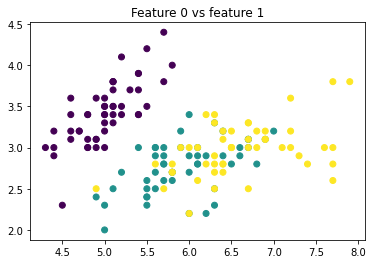

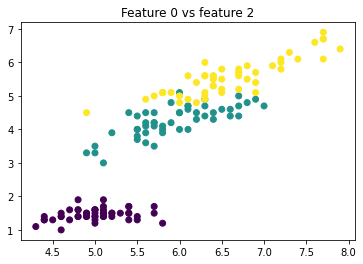

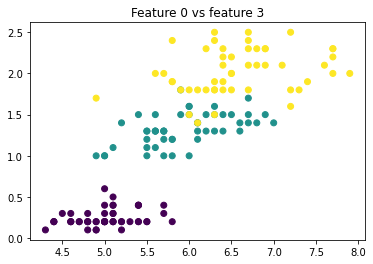

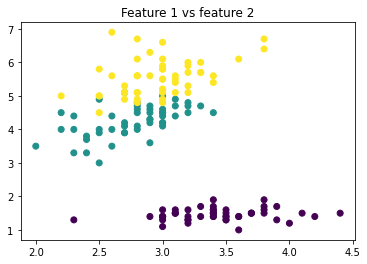

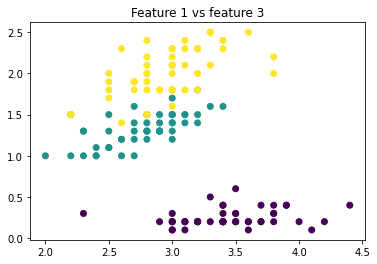

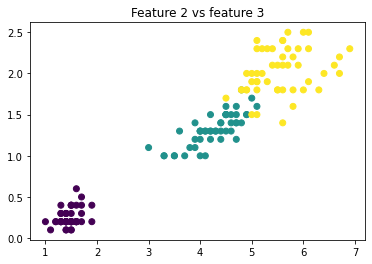

In [ ]:
pairs = list(itertools.combinations(list(range(X.shape[1])),2))
for pair in pairs:
    plt.scatter(X[:,pair[0]], X[:,pair[1]],c=y)
    plt.title(f'Feature {pair[0]} vs feature {pair[1]}')
    plt.show()

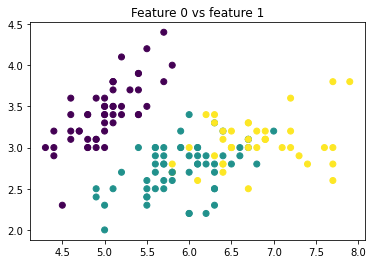

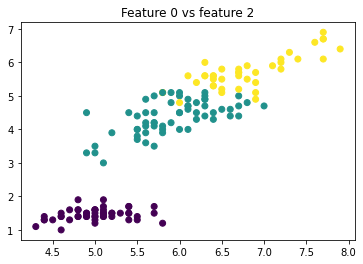

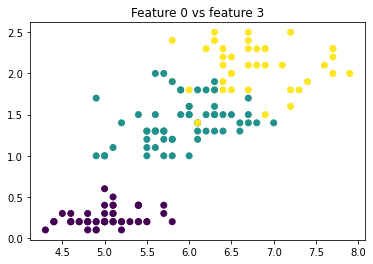

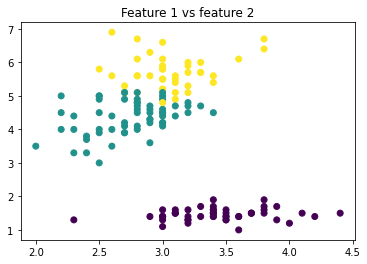

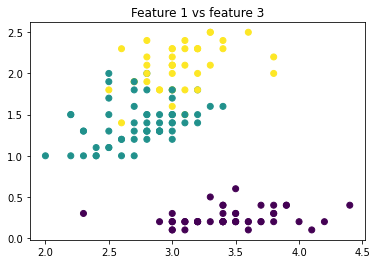

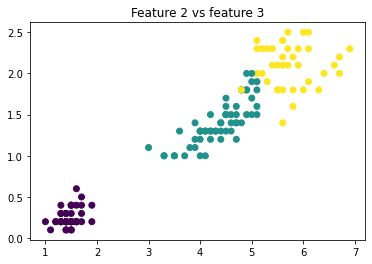

In [ ]:
qkmeans_instances = qkmeans_noisy_instances[0]
n_clusters = 3
pairs = list(itertools.combinations(list(range(X.shape[1])),2))
for pair in pairs:
    plt.scatter(X[:,pair[0]], X[:,pair[1]],c=qkmeans_instances[n_clusters-2].labels_)
    plt.title(f'Feature {pair[0]} vs feature {pair[1]}')
    plt.show()

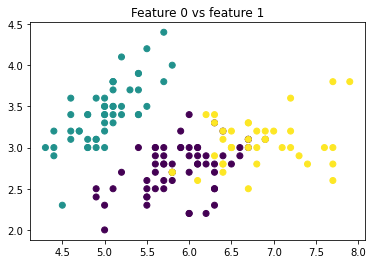

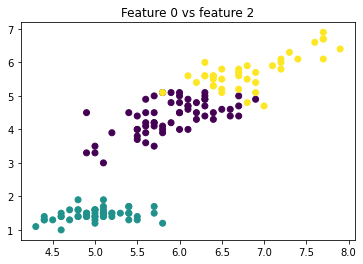

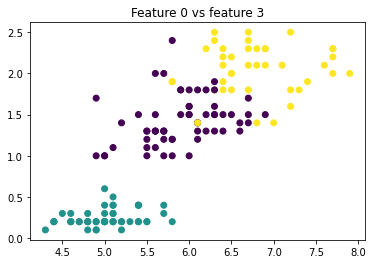

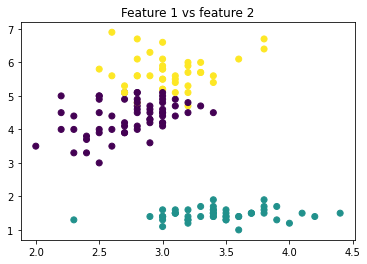

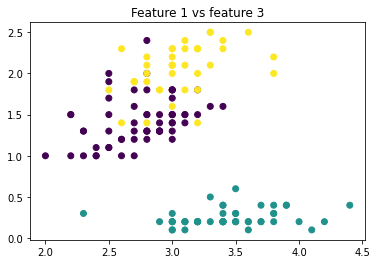

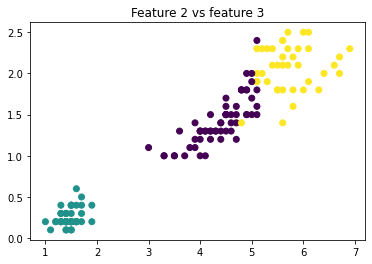

In [ ]:
qkmeans_instances = qkmeans_noisy_instances[-1]
n_clusters = 3
pairs = list(itertools.combinations(list(range(X.shape[1])),2))
for pair in pairs:
    plt.scatter(X[:,pair[0]], X[:,pair[1]],c=qkmeans_instances[n_clusters-2].labels_)
    plt.title(f'Feature {pair[0]} vs feature {pair[1]}')
    plt.show()

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

labels = ['k-means'] + ['e= ' + str(round(num*np.pi/24,3)) for num in range(5)]

noisy_distortions = []
for qkmeans_instances in qkmeans_noisy_instances:
  distortions = []
  mapping1 = {}
  for i in range(2,11):
      distortions.append(sum(np.min(cdist(X, qkmeans_instances[i-2].cluster_centers_,
                                          'euclidean'), axis=1)) / X.shape[0])
      mapping1[i-2] = sum(np.min(cdist(X, qkmeans_instances[i-2].cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0]
  noisy_distortions.append(distortions)

In [ ]:
classical_distortion = []
mapping1 = {}
for i in range(2,11):
    classical_distortion.append(sum(np.min(cdist(X, kmeans_instances[i-2].cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    mapping1[i-2] = sum(np.min(cdist(X, kmeans_instances[i-2].cluster_centers_,
                                  'euclidean'), axis=1)) / X.shape[0]
classical_distortion

[0.8555777695266533,
 0.6480304904934434,
 0.5577656519366712,
 0.509999995678651,
 0.4686562135056527,
 0.43590354365269635,
 0.42916331588713624,
 0.39607957863078574,
 0.3828079578386534]

In [ ]:
colors = ['r','g','b','y','orange','gray']

In [ ]:
labels

['k-means', 'e= 0.0', 'e= 0.131', 'e= 0.262', 'e= 0.393', 'e= 0.524']

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

0 : 0.8555777695266533
1 : 0.6480304904934434
2 : 0.5577656519366712
3 : 0.509999995678651
4 : 0.4686562135056527
5 : 0.43590354365269635
6 : 0.42916331588713624
7 : 0.39607957863078574
8 : 0.3828079578386534


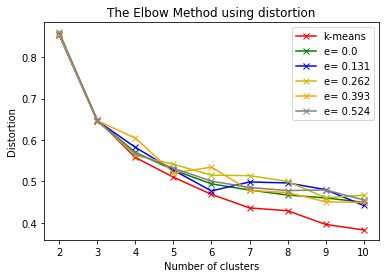

In [ ]:
plt.plot(range(2,11), classical_distortion, 'bx-', c=colors[0], label=labels[0])
for i, distortions in enumerate(noisy_distortions):
  plt.plot(range(2,11), distortions, 'bx-', c=colors[i+1], label=labels[i+1])
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using distortion')
plt.legend()
plt.savefig("qkmeans_iris_distortion.png", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_distortion.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_distortion.svg", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

Davies Bouldin score

In [ ]:
from sklearn.metrics import davies_bouldin_score

noisy_davies_scores = []
for qkmeans_instances in qkmeans_noisy_instances:
  davies_scores = []
  for key, qkmeans_instance in enumerate(qkmeans_instances):
      if key >= 0: 
          davies_scores.append(davies_bouldin_score(X, qkmeans_instance.labels_))
          print(key,':',davies_scores[-1])
  noisy_davies_scores.append(davies_scores)

0 : 0.40429283717304343
1 : 0.6865973453763402
2 : 1.1817407148489298
3 : 1.3307723717471436
4 : 1.5987598665660085
5 : 2.4621382127254146
6 : 2.295018330774899
7 : 2.707644521582966
8 : 2.557408930709252
0 : 0.3962792277246941
1 : 0.693313329487344
2 : 1.2528734006013673
3 : 1.289807276384219
4 : 1.2965168935903468
5 : 2.027149335377468
6 : 2.2202216253601845
7 : 3.1512884651465027
8 : 2.2853491538810013
0 : 0.40429283717304343
1 : 0.6938759646877459
2 : 1.0190902280220406
3 : 1.5015661199593402
4 : 1.7974789189182123
5 : 2.358556629443132
6 : 2.3502579465592373
7 : 3.7282977427008595
8 : 3.1690996476472155
0 : 0.40429283717304343
1 : 0.6795705735658847
2 : 1.1355916465934548
3 : 1.0881270551557747
4 : 3.173118481316482
5 : 2.835878978738552
6 : 1.9098479085451447
7 : 2.0030496699423406
8 : 2.301675861541633
0 : 0.41452778426519094
1 : 0.6900984227580863
2 : 1.048410261587859
3 : 1.3614376453653674
4 : 1.5974158083995844
5 : 1.986970212021802
6 : 2.596820079794318
7 : 2.60707741902372

In [ ]:
davies_scores = []
for key, kmeans_instance in enumerate(kmeans_instances):
    if key >= 0: 
        davies_scores.append(davies_bouldin_score(X, kmeans_instance.labels_))
        print(key,':',davies_scores[-1])
classical_davies_scores = davies_scores

0 : 0.40429283717304343
1 : 0.6619715465007465
2 : 0.7757009440067065
3 : 0.8129584871265321
4 : 0.9386373110649663
5 : 0.9668600960231223
6 : 1.079511213057607
7 : 0.9894229089640579
8 : 1.0331907248812802


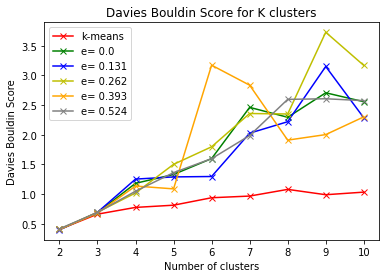

In [ ]:
plt.plot(range(2,11), classical_davies_scores, 'bx-', c=colors[0], label=labels[0])
for i, davies_scores in enumerate(noisy_davies_scores):
  plt.plot(range(2,11), np.array(davies_scores), 'bx-', c=colors[i+1], label=labels[i+1])
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('Davies Bouldin Score for K clusters')
plt.legend()
plt.savefig("qkmeans_iris_davies_bouldin.png", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_davies_bouldin.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_davies_bouldin.svg", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

Calinski Harabasz score

In [ ]:
from sklearn.metrics import calinski_harabasz_score

noisy_calinski_scores = []
for qkmeans_instances in qkmeans_noisy_instances:
  calinski_scores = []
  for key, qkmeans_instance in enumerate(qkmeans_instances):
      if key >= 0: 
          calinski_scores.append(calinski_harabasz_score(X, qkmeans_instance.labels_))
          print(key,':',calinski_scores[-1])
  noisy_calinski_scores.append(calinski_scores)

0 : 513.9245459802768
1 : 541.3056859684049
2 : 366.1174643848679
3 : 301.6498709211498
4 : 251.58027071787674
5 : 225.36080086892153
6 : 199.55065620413495
7 : 176.05156284083768
8 : 157.88841429741805
0 : 511.9547613825613
1 : 539.2723867344306
2 : 380.4853057376993
3 : 303.0655846349519
4 : 288.92494790331295
5 : 212.9468802859829
6 : 170.71359148308275
7 : 164.8520027258832
8 : 152.594075895764
0 : 513.9245459802768
1 : 540.7483277289244
2 : 411.9873204241607
3 : 290.04208872621393
4 : 244.2720758909523
5 : 208.76344314000033
6 : 171.36405993651985
7 : 168.4719196157761
8 : 133.8591127834721
0 : 513.9245459802768
1 : 552.9906927324834
2 : 322.76371352226073
3 : 352.8025226752277
4 : 246.50992888121587
5 : 255.31281055345826
6 : 170.37071036179108
7 : 167.1840132296628
8 : 153.2298975244692
0 : 510.10541656967
1 : 538.5861906813451
2 : 365.2404681084925
3 : 313.1416104183996
4 : 251.57043709746017
5 : 233.37551474979347
6 : 169.31368797600615
7 : 158.58079234122073
8 : 145.915612366

In [ ]:
calinski_scores = []
for key, kmeans_instance in enumerate(kmeans_instances):
    if key >= 0: 
        calinski_scores.append(calinski_harabasz_score(X, kmeans_instance.labels_))
        print(key,':',calinski_scores[-1])
classical_calinski_scores = calinski_scores

0 : 513.9245459802768
1 : 561.62775662962
2 : 530.4871420421674
3 : 492.5118727663631
4 : 471.32290565747684
5 : 449.6410352248477
6 : 399.7248381402108
7 : 408.0606074535746
8 : 391.4141216017138


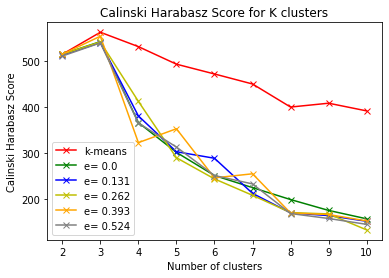

In [ ]:
plt.plot(range(2,11), classical_calinski_scores, 'bx-', c=colors[0], label=labels[0])
for i, calinski_scores in enumerate(noisy_calinski_scores):
  plt.plot(range(2,11), calinski_scores, 'bx-', c=colors[i+1], label=labels[i+1])
plt.xlabel('Number of clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('Calinski Harabasz Score for K clusters')
plt.legend()
plt.savefig("qkmeans_iris_calinski_harabasz.png", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_calinski_harabasz.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_calinski_harabasz.svg", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

Silhouette score

In [ ]:
from sklearn.metrics import silhouette_score

noisy_silhouette_scores = []
for qkmeans_instances in qkmeans_noisy_instances:
  silhouette_scores = []
  for key, qkmeans_instance in enumerate(qkmeans_instances):
      if key >= 0: 
          silhouette_scores.append(silhouette_score(X, qkmeans_instance.labels_, metric='euclidean'))
          print(key,':',silhouette_scores[-1])
  noisy_silhouette_scores.append(silhouette_scores)

0 : 0.6810461692117462
1 : 0.536623768595717
2 : 0.36055862848703885
3 : 0.3462688368813279
4 : 0.13927648605751897
5 : 0.12983039386509496
6 : 0.07101883858410783
7 : 0.10324183622250584
8 : 0.01528221352437327
0 : 0.6832688659478873
1 : 0.5307588871029104
2 : 0.39969070495015285
3 : 0.36007363088895405
4 : 0.20197284334743595
5 : 0.12935424113475052
6 : 0.24243639771654338
7 : 0.05986122601808668
8 : 0.01082450145541944
0 : 0.6810461692117462
1 : 0.5314171721415436
2 : 0.41590823928971593
3 : 0.16072000289203842
4 : 0.15377922923004575
5 : 0.2681764726876166
6 : 0.23064686275342447
7 : 0.05698173940860772
8 : 0.009626901685786038
0 : 0.6810461692117462
1 : 0.5416218769134711
2 : 0.2947615098810878
3 : 0.3943909588976354
4 : 0.14382737666794565
5 : 0.151648912069181
6 : 0.08721469128822944
7 : 0.05028162092316922
8 : 0.016748761098290224
0 : 0.6772307917547696
1 : 0.5340723642502693
2 : 0.3982498102764239
3 : 0.2135003945256385
4 : 0.17336478069736436
5 : 0.08937592423950551
6 : 0.037

In [ ]:
silhouette_scores = []
for key, kmeans_instance in enumerate(kmeans_instances):
    if key >= 0: 
        silhouette_scores.append(silhouette_score(X, kmeans_instance.labels_, metric='euclidean'))
        print(key,':',silhouette_scores[-1])
classical_silhouette_scores = silhouette_scores

0 : 0.6810461692117462
1 : 0.5528190123564095
2 : 0.4974551890173751
3 : 0.49394444148143263
4 : 0.35876521549077683
5 : 0.3588294450965685
6 : 0.31236138665965674
7 : 0.3428163783556832
8 : 0.312959537519812


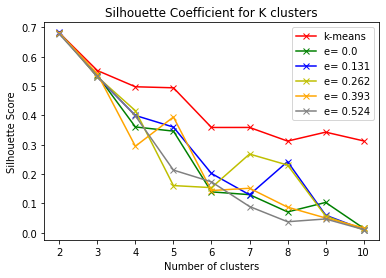

In [ ]:
plt.plot(range(2,11), classical_silhouette_scores, 'bx-', c=colors[0], label=labels[0])
for i, silhouette_scores in enumerate(noisy_silhouette_scores):
  plt.plot(range(2,11), silhouette_scores, 'bx-', c=colors[i+1], label=labels[i+1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Coefficient for K clusters')
plt.legend()
plt.savefig("qkmeans_iris_silhouette.png", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_silhouette.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.savefig("qkmeans_iris_silhouette.svg", transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()